# Linear Regression

The **linear regression** model is a linear function that maps features to a target value. A standard linear regression model has parameters *w* (weight(s)), and *b* (bias). Each feature gets its own weight.

Say, there are 2 features, then:

$$
\begin{aligned}
f_( w_1, w_2, b_) (x) &= w_1x_1 + w_2x_2 + b \\
\end{aligned}
$$

, where *x* is the input.

In order to know what values to use for the parameters *w* and *b* of our model, we need a loss function. The loss function takes a model as its argument,

$$ \text{model}: \text{data} \;\mapsto\; \text{output} $$

$$ \text{loss function}: \text{model} \;\mapsto\; \text{loss value} $$




We can plot the loss for every point in our model space. This is called the **loss surface**, or the loss landscape. To search for the lowest point in the loss surface, we use **optimisation**:

$$
\begin{aligned}
\hat{p} = \arg\min_{p} \; \text{loss}_{X,T}(p)
\end{aligned}
$$

, where *X* is the input data, *T* is the target (what we want the model to predict), and $\hat{p}$ is the best *set* of parameters for the model.

## 0. Necessary Imports

In [258]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes

from matplotlib.figure import Figure
from matplotlib.axes._axes import Axes

from typing import List, Tuple

**NOTE:** We will make use of typehints. I find it very important to always keep track of what the type of a variable is that we are creating. This essentially helps us understand our code. And not just that, it also makes it easier to find causes of errors/problems we might face during development.

## 1. Dataset

We are using the scikit-learn diabetes dataset, but will only consider one feature: the BMI. Using one feature makes visualisation easier. Luckily, all input features (including BMI) were standardised before being stored in the dataset.

In [259]:
diabetes = load_diabetes()

In [260]:
X: np.ndarray[np.float64] = diabetes.data[:,2]
y: np.ndarray[np.float64] = diabetes.target

We'll also split the data 80/20 for training and testing respectively. This is often regular practise. We won't consider a validation set in this notebook.

In [261]:
m: int = int(len(X) * 0.8)
X_train, X_test = X[:m], X[m:]
y_train, y_test = y[:m], y[m:]

In [262]:
def plot_data(
    X: np.ndarray[np.float64],
    y: np.ndarray[np.float64],
) -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    ax.scatter(
        x=X,
        y=y,
        alpha=0.7
    )
    ax.set_xlabel("BMI (standardised)")
    ax.set_ylabel("disease progression score")
    ax.set_title("diabetes dataset: BMI vs disease progression")
    return fig, ax

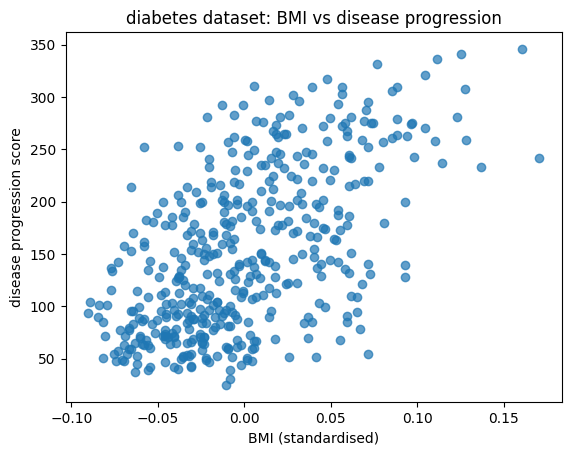

In [263]:
fig, ax = plot_data(
    X=X,
    y=y,
)

We'll also define a function that will help us visualise the regression line.

In [264]:
def plot_regression_line(
    X: np.ndarray[np.float64],
    y: np.ndarray[np.float64],
    w: float,
    b: float,
    color: str = "red",
) -> Tuple[Figure, Axes]:
    """Plot data scatter + fitted regression line."""
    fig, ax = plt.subplots()

    ax.scatter(
        x=X,
        y=y,
        alpha=0.3,
        label="data",
    )

    x_flat: np.ndarray[np.float64] = np.ravel(X)
    x_line: np.ndarray[np.float64] = np.linspace(
        x_flat.min(),
        x_flat.max()
    )
    y_line: np.ndarray[np.float[64]] = w * x_line + b

    ax.plot(
        x_line,
        y_line, 
        color=color,
        label="prediction line",
    )

    ax.set_xlabel("BMI (standardised)")
    ax.set_ylabel("disease progression")
    ax.set_title("diabetes dataset: BMI vs. disease progression")
    ax.legend()
    
    return fig, ax

## 2. Initialising The Model

Initialising our model is very easy, the model will just perform very poorly. Unless we are very lucky, and somehow choose an optimal set of parameters. However, being very lucky, basically implies that something is very unlikely. So, let's initialise our model for now, and we will gradually see how our model will improve.

$$
\begin{aligned}
f_( w_1, b_) (x) &= w_1x_1 + b \\
\end{aligned}
$$

We know that we are working with 1 feature, so we only consider weight 1 $w_1$ (and of course a bias $b$). We haven't assigned any values to the parameters yet, but that is of later concern.

**NOTE:** A model is nothing more than a function. The word 'model' is just fancy machine learning terminology.


Essentially, the goal is to fit the line to the data. To get the idea. We'll first look at some random line, and see why it does or doesn't fit. We will look at the solution as well, so we can see what we are really trying to achieve. I wrote down some random weight and bias, so that we can see that guessing is a really inefficient strategy to solve the problem. But most of all, we can see what we are trying to acieve.

**NOTE:** Until section 6, we will only be working with the training data. After, we will test our model on the test data.

In [265]:
rand_w: int = 123
rand_b: int = 123
rand_x = np.linspace(X_train.min(), X_train.max())
rand_y_hat = rand_w*rand_x + rand_b

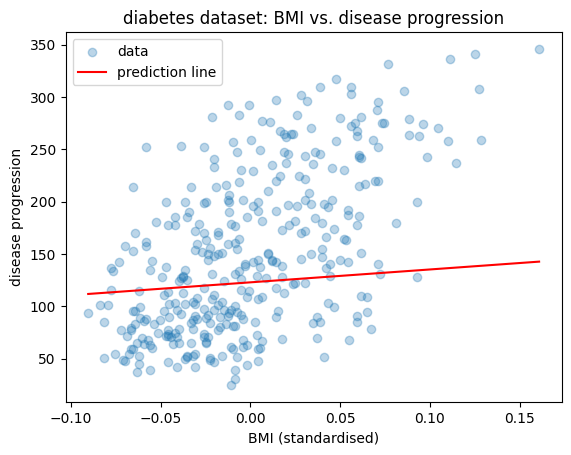

In [266]:
fig, ax = plot_regression_line(
    X=X_train,
    y=y_train,
    w=rand_w,
    b=rand_b,
)

Again, our goal is to fit a line to the data. And as we can see, the line does not really follow the pattern of the data. We can of course approximate the solution, and we would basically have a fitting line. However, in higher dimension (3 or more dimensions) it will be impossible (nearly) to approximate a perfect line ourselves. We chose 1 feature so that we can really see what is happing.

## 3. Loss Function

To build a machine learning algorithm, we will need a loss function. We will use the residual sum of squares as our loss function (RSS), and we will implement it ourselves. Here is the RSS function as a regular math expression:

$$
\begin{aligned}
\text{RSS}(f_p) \;=\; \frac{1}{2} \sum_{i=1}^{n} \Big( f_p(x_i) - y_i \Big)^2
\end{aligned}
$$?

, where *n* is the number of data instances, $f_p(x_j)$ is the model's prediction for a given input (data instance, $x_j$), and $y_j$ is the target value (the actual value that x belongs to).

The difference between the model's prediction and target value is squared, so that the outcome is always positive. If we wouldn't do so, our loss could fluctuate between negative and positive values, where really it should be consistently positive so the loss adds up. Furthermore, squaring is useful to highlight predictions that are far off of the target value, or possible outliers in the data.

## 4. Calculating Gradients

To train our model, we will need to update our weights accordingly. To update our weights, we will use **gradient descent**. A gradient is essentially the *slope* of a line. Say a slope is 2, then that implies that when we were to move 1 step to the right (x-axis), we move 2 steps up (y-axis). From basic calculus, we know that we can find the slope by calculating the *derivative*. But in our case, the function that we are differentiating is the RSS function, with our weight, bias, input, and output. So, let's do so, and I will explain everything afterwards.

But first, let's understand the update rule. Here, you can see the update rule we are working with. *w* and *b* are our parameters.

$$
\begin{pmatrix}
w \\
b
\end{pmatrix}
\leftarrow
\begin{pmatrix}
w \\
b
\end{pmatrix}
- \eta
\begin{pmatrix}
\frac{\partial \, \text{loss}}{\partial w} \\
\frac{\partial \, \text{loss}}{\partial b}
\end{pmatrix}
$$

On the right side of our arrow we have the current *w* and *b*, and our partial derivatives multiplied by $\eta$ (learning rate).

---

### Loss function

$$
\text{loss} = \tfrac{1}{2} \sum_i (w x_i + b - y_i)^2
$$

---

### Gradient with respect to ***w***

$$
\frac{\partial \, \text{loss}}{\partial w}
= \frac{1}{2} \sum_i \frac{\partial}{\partial w} \big( (w x_i + b - y_i)^2 \big)
$$

$$
= \tfrac{1}{2} \sum_i 2 (w x_i + b - y_i) \cdot \frac{\partial}{\partial w}(w x_i + b - y_i)
$$

$$
= \sum_i (w x_i + b - y_i) \cdot x_i
$$

$$
= w \sum_i x_i^2 + b \sum_i x_i - \sum_i y_i x_i
$$

---

### Gradient with respect to ***b***

$$
\frac{\partial \, \text{loss}}{\partial b}
= \frac{1}{2} \sum_i \frac{\partial}{\partial b} \big( (w x_i + b - y_i)^2 \big)
$$

$$
= \tfrac{1}{2} \sum_i 2 (w x_i + b - y_i) \cdot \frac{\partial}{\partial b}(w x_i + b - y_i)
$$

$$
= \sum_i (w x_i + b - y_i) \cdot 1
$$

$$
= \sum_i (w x_i + b - y_i)
$$

$$
= w \sum_i x_i + b n - \sum_i y_i
$$

---

If this all seems like abra-kadabra to you, I understand. But we all have to learn it at some point. I will try to briefly explain what happens during the calculations. If it appears to be too difficult to understand, I highly encourage you to study some calculus (and linear algebra, eventually) if you are planning to continue your career on this path. 

The first formula, the one we already briefly discussed, seems crazy, but really isn't. The weird looking d we see, $\partial$, is simply a delta, which is how we define that we are differentiating something. However, instead of regular differntiating, we are partially differentiating, once for every parameter. So first, we differentiate ***f*** with respect to *w*, and then with respect to *b*. Let's look at a simple example. We will use $f(x, y) = x^2 y + 3x y^2$ as our formula for this purpose. Now, instead of *w* and *b*, *x* and *y* are our parameters.


---

#### Partial derivative with respect to *x*

$$
\frac{\partial f}{\partial x}
= \frac{\partial}{\partial x} \big( x^2 y + 3x y^2 \big)
$$

$$
= \frac{\partial}{\partial x}(x^2 y) + \frac{\partial}{\partial x}(3x y^2)
$$

$$
= 2xy + 3y^2
$$

---

#### Partial derivative with respect to *y*

$$
\frac{\partial f}{\partial y}
= \frac{\partial}{\partial y} \big( x^2 y + 3x y^2 \big)
$$

$$
= \frac{\partial}{\partial y}(x^2 y) + \frac{\partial}{\partial y}(3x y^2)
$$

$$
= x^2 + 6xy
$$

---


**NOTE:** If you are still not following along, again, I encourage you to study some calculus by yourself. A good place to start is https://www.video-tutor.net/calculus.html. This course is free, and discusses many different topics regarding calculus. They also provide an algebra, and precalculus course. I recommend following those courses first if you are really unfamiliar with math in general.

Enough on paper, let's move to the implementation. We found the solutions to the partial derivatives, and now we hope to see that our solutions really work. The update rule we define takes the previous weight *w_old*, previous bias *b_old*, inputs *x* in X, outputs *y* in Y, and has some learning rate (*lr*). The update rule returns the new weight, and new bias, and will then perform the same calculations on those, until we are out of runs.

In [267]:
def update_weights(
    w_old: np.float64,
    b_old: np.float64,
    X: np.ndarray[np.float64],
    y: np.ndarray[np.float64],
    lr: float,
) -> Tuple[np.float64]:
    
    n: int = len(X)
    
    gradient_w: np.float64 = (
        w_old * np.sum([x**2 for x in X]) +
        b_old * np.sum(X) -
        np.sum([x*y_ for x, y_ in zip(X,y)])
    )

    gradient_b: np.float64 = (
        w_old * np.sum(X) +
        (b_old * n) -
        np.sum(y)
    )

    w_new: np.float64 = w_old - lr * gradient_w 
    b_new: np.float64 = b_old - lr * gradient_b
    
    return w_new, b_new

## 5. Training the Linear Regression Model

Now that we have our update rule set, we can start training the model. We will start with a value of 1 for both parameters *w* and *b*. This could be any number, but it does not really matter how we initialise our parameters. If our implementation is correct, the weight and bias should be optimised correctly.

We will update the weight and bias 15000 times. Since our learning rate is relatively low, we need to perform many runs before we get to a significat solution. The learning rate parameter is very important. Namely, if we set the learning rate too high, we might miss the optimal solution. On the other hand, if it is too low, we might not reach it within our number of runs.

**NOTE:** The learning rate might sometimes be referred to as the **step size**. In mathematical notation, the step size is often written as $\alpha$ (alpha).

In [268]:
runs: int = 15000
w, b = 1, 1
for _ in range(runs):
    w, b = update_weights(
        w_old=w,
        b_old=b,
        X=X_train,
        y=y_train,
        lr=0.001,
    )

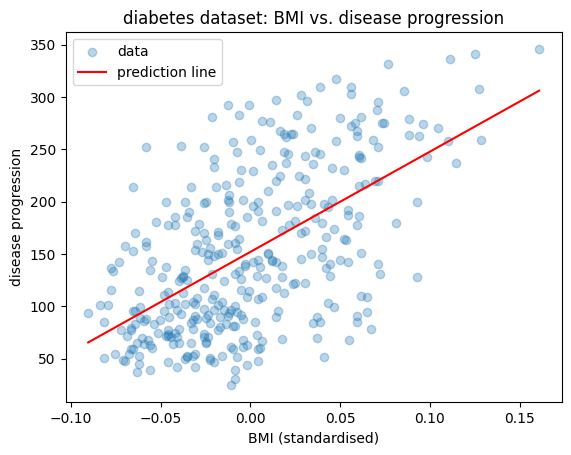

In [269]:
fig, ax = plot_regression_line(
    X=X_train,
    y=y_train,
    w=w,
    b=b,
)

Great! Apparantly, our update rule works, and our calculations are right (of course). We can see that we managed to fit the line to the data. But still, let's evaluate our model's performance.

## 6. Evaluating our Linear Regression Model

Now, we will evaluate our model. We will need our test data to test our model, and see how it performs. Let's first visualise the test data, and see how our line (model) performs when only test data is considered.

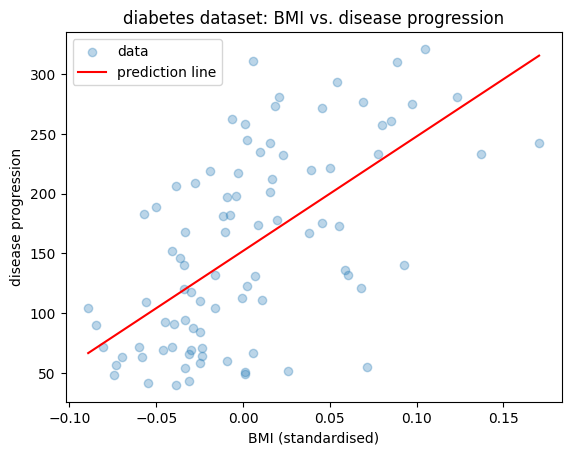

In [270]:
fig, ax = plot_regression_line(
    X=X_test,
    y=y_test,
    w=w,
    b=b,
)

Let's now move to actually evaluating our model. To evaluate, we will calculate our model's prediction for every instance *x* in our test dataset, *X_test*. We will compare this prediction to every target value *y* in our test dataset, *y_test*.

To evaluate our model, we will be using 2 functions: the **mean squared error (MSE)**, and the **coefficient of determination ($R^2$)**. These will help us understand the performance of our model.

The mean squared error between predictions $f_p(x_i)$ and true values $y_i$ is:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (f_p(x_i) - y_i)^2
$$

Essentially, the MSE tells us the average squared distance between predictions and true values. A small MSE implies that our predictions are *close* to reality. On the other hand, a large MSE implies that our predictions are *far* off from the real data.

In [271]:
def mse(
    X: List[np.float64],
    y: List[np.float64],
    w: np.float64,
    b: np.float64,
) -> np.float64:
    
    return (1/len(X)) * np.sum(
        [(w * x_ + b - y_)**2 for x_, y_ in zip(X,y)]
    )

In [272]:
optimised_ = mse(
    X=X_test,
    y=y_test,
    w=w,
    b=b
)
int(optimised_)

4079

I agree, it is still a large number, and you would like the MSE result to be as close to 0 as possible. But trust me, it is already significantly smaller than our initial guess, where we set *w* = 123, and *b* = 123.

In [273]:
guess_ = mse(
    X=X_test,
    y=y_test,
    w=123,
    b=123,
)

int(
    np.abs(
        optimised_ - guess_
    )
)

2747

A difference of nearly 3000 (!). So indeed, our model did improve. It is mostly due to the way the data is spread that makes it hard to really fit a line to the data. However, the MSE does not describe everything. We still have $R^2$ to cover.

The coefficient of determination compares the squared error of the model to the variance in the data:

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

, where $y_i$ are the true values, $\hat{y}_i$ are the predicted values, and $\bar{y}$ is the mean of the true values.


In [274]:
y_bar = y_test.mean()

def r2(
    X: np.ndarray[np.float64],
    y: np.ndarray[np.float64],
    w: np.float64,
    b: np.float64,
) -> np.float64:
    
    numerator = np.sum(
        [(w * x_ + b - y_)**2 for x_, y_ in zip(X,y)]
    )
    denominator = np.sum(
        [(y_ - y.mean())**2 for y_ in y]
    )

    return 1 - (numerator / denominator)

In [275]:
cod = r2(
    X=X_test,
    y=y_test,
    w=w,
    b=b
)

explained_ = str(int(cod * 100)) + "%"
explained_

'36%'

Our linear regression model using only BMI as input achieved an $R^2$ of about 0.36, meaning it explains roughly a third of the variance in disease progression. This implies that BMI is somewhat informative, but not nearly enough to capture the complexity of the problem on its own. The remaining variance must be explained by other features such as age, blood pressure, or blood sugar, which were deliberately ignored here to keep the problem simple and interpretable. This is the core reason that it might *seem* our model 'failed', but it really hasn't. We managed to optimise the model with the data we used.

## 7. Conclusion

So, is our model bad, or good? The answer is, really neither. Of course, if we had considered all features, the model would've likely done way better. But again, we would find ourselves in a higher dimension, which is difficult (or even impossible) to visualise and understand. The purpose of this notebook was not to build a high-performing model, but to show how machine learning works under the hood: from defining a model, to training it with gradient descent, to evaluating it with metrics. In that sense, the exercise is a success.

A natural next step would be to extend the model with multiple features, which would improve predictive accuracy at the cost of visualisation. This trade-off reflects a common theme in machine learning: balancing simplicity and interpretability with performance.